# Qubit decay from Monte Carlo point of view
Gengyan Zhang, Novemer 18 2017

**Reference**: S. Haroche and J.-M. Raimond. *Exploring the Quantum: Atoms, Cavities, and Photons*. Oxford University Press, 2006. Section 4.3 & 4.4.

The dynamics of an open quantum system $\rho$ can be described by the master equation in Lindblad form
$$\frac{d\rho}{dt}=-\frac{i}{\hbar}[H, \rho]+\sum_{\mu}{\left(L_\mu\rho L_\mu^\dagger-\tfrac{1}{2}L_\mu^\dagger L_\mu\rho-\tfrac{1}{2}\rho L_\mu^\dagger L_\mu\right),}$$
where $L_\mu$'s are collapse operators.

Assume the state of the system at time $t$ is $|\psi(t)\rangle$. In Monte Carlo simulations, the state at time $t+dt$ is determined by the following recipe:
- There is probability $p_0=1-dt\sum_\mu{\langle\psi(t)|L_\mu^\dagger L_\mu|\psi(t)\rangle}$ that **no jump** occurs. In this case, the resulting state is evolution under **non Hermitian** Hamiltonian $H_e=H-i\hbar J$,
$$|\psi(t+dt)\rangle = \frac{1-iH\cdot dt/\hbar-J\cdot dt}{\sqrt{p_0}}|\psi(t)\rangle,$$
where $J = \frac{1}{2}\sum_\mu{L_\mu^\dagger L_\mu}$.
- There is probability $p_\mu=dt\langle\psi(t)|L_\mu^\dagger L_\mu|\psi(t)\rangle$ that **a jump** occurs. In this case, the state is **collapsed** by $L_\mu$,
$$\psi(t+dt)=\frac{L_\mu|\psi(t)\rangle}{\sqrt{p_\mu/dt}}.$$

We use QuTiP to study some simple examples and illustrate the above discussion.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
plt.rc('font', size=14)

In [2]:
sm = qt.sigmam()
sx = qt.sigmax()
sz = qt.sigmaz()

def MonteCarlo():
    '''
    Function that calculates three Monte Carlo trajectories and the ensemble averaged time evolution.
    Relevant parameters are defined outside the function as global variables.
    '''
    traj = np.zeros((3, len(tlist)))
    for ii in range(3):
        result = qt.mcsolve(H, psi0, tlist, cops, eops, ntraj=1,
                            options=qt.Options(seeds=[seedlist[ii]]),
                            progress_bar=False)
        traj[ii, :] = np.real(result.expect[0])
    # Use master equation solver to calculate ensemble averaged result
    result = qt.mesolve(H, psi0, tlist, cops, eops)
    return np.vstack((traj, np.real(result.expect[0])))

## Spontaneous decay
There is only one collapse operator $L_1=\sqrt{\Gamma}\sigma_-$, corresonding to the $|e\rangle\rightarrow|g\rangle$ process with rate $\Gamma$. The initial state is $|\psi(0)\rangle=|e\rangle$. In the rotating frame of qubit, the Hamiltonian is identity operator, and the non Hermitian Hamiltonian is $-i\hbar J=-i\hbar\frac{\Gamma}{2}\sigma_+\sigma_-$.

If no jump occurs, the evolution is $|\psi(t)\rangle\propto e^{-Jt}|\psi(0)\rangle=e^{-\Gamma\sigma_+\sigma_-t/2}|e\rangle=|e\rangle$, and the state remains excited.

If a jump occurs, the state collapses to $|\psi(t)\rangle=\sigma_-|e\rangle=|g\rangle$,
and stays at ground state after the jump.

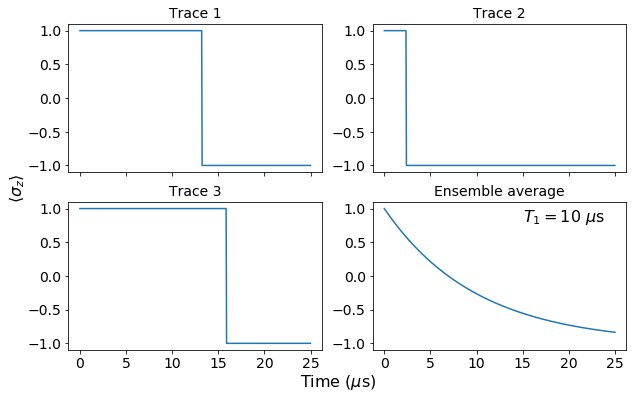

In [3]:
tlist = np.linspace(0, 25, 501)  # Time axis
seedlist = np.array([27418730,  22060235,  28654686], dtype=int)  # Use specific seeds to ensure same result

T1 = 10  # T1
cops = [np.sqrt(1/T1)*sm]  # Collapse operator
eops = [sz]
H = qt.qeye(2)
psi0 = qt.basis(2, 0)  # Initial state

# Run Monte Carlo simulation
result = MonteCarlo()

# Plot results
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 6))
for ii in range(4):
    plt.subplot(2, 2, ii+1)
    plt.plot(tlist, result[ii, :])
    if ii < 3:
        plt.title('Trace ' + str(ii+1), fontsize=14)
    else:
        plt.text(15, 0.8, r'$T_1=10\ \mu$s', fontsize=16)
        plt.ylim([-1.1, 1.1])
        plt.title('Ensemble average', fontsize=14)
    if ii < 2:
        plt.gca().set_xticklabels([])
fig.text(0.5, 0.04, r'Time ($\mu$s)', ha='center', fontsize=16)
fig.text(0.04, 0.5, r'$\langle\sigma_z\rangle$', va='center', rotation='vertical', fontsize=16)

plt.show()

## Pure dephasing
The collapse operator is $L_1=\sqrt{\frac{\Gamma_\varphi}{2}}\sigma_z$. Assume at time $t$ the state is $|\psi(t)\rangle=(|g\rangle+e^{i\varphi}|e\rangle)/\sqrt{2}$.

If no jump occurs, because $J=\frac{1}{2}\sigma_z\sigma_z\propto\mathbb{1}$, the state remains the same.

If a jump occurs, the state jumps to $|\psi(t+dt)\rangle=\sigma_z(|g\rangle+e^{i\varphi}|e\rangle)/\sqrt{2}=(-|g\rangle+e^{i\varphi}|e\rangle)/\sqrt{2}$,
and phase of the qubit jumps by $\pi$.

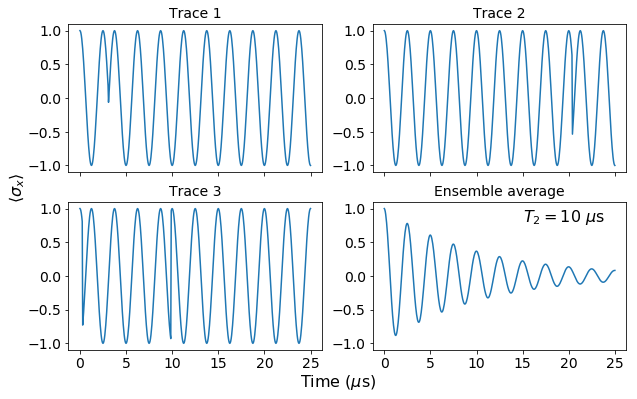

In [4]:
tlist = np.linspace(0, 25, 501)
seedlist = np.array([32829112,  70571710,  34772702], dtype=int)

T2 = 10
Delta = 0.4*2*np.pi  # Include detuning to see the phase jumps easier
cops = [np.sqrt(.5/T2)*sz]  # Collapse operator for pure dephasing
eops = [sx]
H = Delta/2*sz
psi0 = (qt.basis(2, 0) + qt.basis(2, 1)).unit()

result = MonteCarlo()

# Plot results
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 6))
for ii in range(4):
    plt.subplot(2, 2, ii+1)
    plt.plot(tlist, result[ii, :])
    if ii < 3:
        plt.title('Trace ' + str(ii+1), fontsize=14)
    else:
        plt.text(15, 0.8, r'$T_2=10\ \mu$s', fontsize=16)
        plt.ylim([-1.1, 1.1])
        plt.title('Ensemble average', fontsize=14)
    if ii < 2:
        plt.gca().set_xticklabels([])
fig.text(0.5, 0.04, r'Time ($\mu$s)', ha='center', fontsize=16)
fig.text(0.04, 0.5, r'$\langle\sigma_x\rangle$', va='center', rotation='vertical', fontsize=16)

plt.show()

## Non Hermitian evolution
A more subtle case is the spontaneous decay when the initial state is $|\psi(0)\rangle=(|g\rangle+|e\rangle)/\sqrt{2}$. The collapse operator is again $L_1=\sqrt{\Gamma}\sigma_-$ and the non Hermitian Hamiltonian is $-i\hbar J = -i\hbar\frac{\Gamma}{2}\sigma_+\sigma_-$.

When no jump occurs, the non Hermitian evolution is
$$|\psi(t)\rangle = \frac{1}{\sqrt{p(t)}}e^{-Jt}|\psi(0)\rangle=\frac{1}{\sqrt{p(t)}}\frac{e^{-\Gamma t/2}|e\rangle+|g\rangle}{\sqrt{2}},$$
and $p(t) = \dfrac{1+e^{-\Gamma t}}{2}$ can be determined by the normalization condition of $|\psi(t)\rangle$.

When a jump occurs, the state collapses to $|g\rangle$.

We see that $\lim_{t\rightarrow\infty}p(t)=0.5$, so (quoting Haroche book) *there is 1/2 probability of emitting at some time a photon and the same probability of never emitting one. Half of the Monte Carlo trajectories will thus exhibit a jump, and the other half not. In all cases, if we wait long enough, the atom will however be found in the ground state $|g\rangle$*. In the case when no jump occurs, *the system’s wave function then evolves not because a physical emission process occurred, but because the knowledge about the system has changed. If no photon is detected during a time interval, it becomes logically more likely that the atom is in the state which cannot emit light. The non-unitary part of the Monte Carlo wave function evolution thus accounts for an acquisition of information due to a negative measurement*.

We can calculate the ensemble averaged evolution of $\langle\sigma_z\rangle$ and $\langle\sigma_x\rangle$ following the above analysis.

When no jump occurs, the expection values of $\sigma_z$ and $\sigma_x$ are
$$\langle\sigma_z\rangle^\text{no jump}=\langle\psi(t)|\sigma_z|\psi(t)\rangle=\frac{e^{-\Gamma t}-1}{e^{-\Gamma t}+1},\quad
\langle\sigma_x\rangle^\text{no jump}=\langle\psi(t)|\sigma_x|\psi(t)\rangle=e^{-\Gamma t/2}.$$
When jump occurs, we have $\langle\sigma_z\rangle^\text{jump}=-1,\quad
\langle\sigma_x\rangle^\text{jump}=0.$

Therefore, we get
$$\begin{aligned}
\langle\sigma_z(t)\rangle&=p(t)\langle\sigma_z\rangle^\text{no jump}+(1-p(t))\langle\sigma_z\rangle^\text{jump}=e^{-\Gamma t}-1,\\
\langle\sigma_x(t)\rangle&=p(t)\langle\sigma_x\rangle^\text{no jump}+(1-p(t))\langle\sigma_x\rangle^\text{jump}=e^{-\Gamma t/2}.
\end{aligned}$$
Those results match the $T_1$ and $T_2$ processes that we expect.

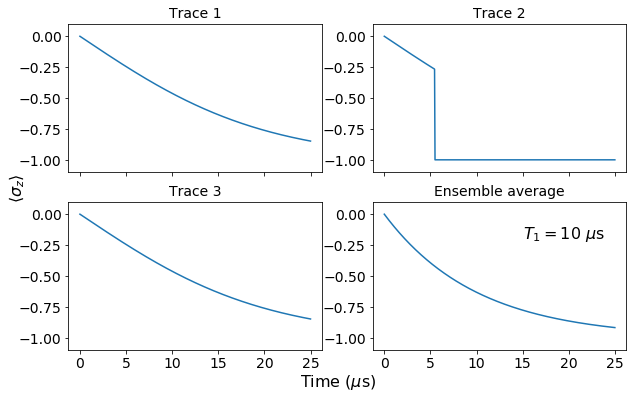

In [5]:
tlist = np.linspace(0, 25, 501)
seedlist = np.array([27418730, 22060235, 28654686], dtype=int)

T1 = 10
cops = [np.sqrt(1/T1)*sm]
eops = [sz]
H = qt.qeye(2)
psi0 = (qt.basis(2, 0) + qt.basis(2, 1)).unit()

result = MonteCarlo()

# Plot results
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 6))
for ii in range(4):
    plt.subplot(2, 2, ii+1)
    plt.plot(tlist, result[ii, :])
    if ii < 3:
        plt.title('Trace ' + str(ii+1), fontsize=14)
        plt.ylim([-1.1, 0.1])
    else:
        plt.text(15, -0.2, r'$T_1=10\ \mu$s', fontsize=16)
        plt.ylim([-1.1, 0.1])
        plt.title('Ensemble average', fontsize=14)
    if ii < 2:
        plt.gca().set_xticklabels([])
fig.text(0.5, 0.04, r'Time ($\mu$s)', ha='center', fontsize=16)
fig.text(0.04, 0.5, r'$\langle\sigma_z\rangle$', va='center', rotation='vertical', fontsize=16)

plt.show()

We see that Trace 1 and 3 show no jump but decay continuously; Trace 2 shows a jump and collapsed to $|g\rangle$. To see the statistics of the  trajectories, we run 5000 trajectories in the following code.

10.0%. Run time:   8.31s. Est. time left: 00:00:01:14
20.0%. Run time:  16.55s. Est. time left: 00:00:01:06
30.0%. Run time:  24.75s. Est. time left: 00:00:00:57
40.0%. Run time:  33.09s. Est. time left: 00:00:00:49
50.0%. Run time:  41.30s. Est. time left: 00:00:00:41
60.0%. Run time:  49.49s. Est. time left: 00:00:00:32
70.0%. Run time:  58.87s. Est. time left: 00:00:00:25
80.0%. Run time:  69.23s. Est. time left: 00:00:00:17
90.0%. Run time:  79.23s. Est. time left: 00:00:00:08
100.0%. Run time:  89.32s. Est. time left: 00:00:00:00
Total run time:  89.40s

Total number of trajectories:  5000
Number of trajectories that contain jumps:  2491


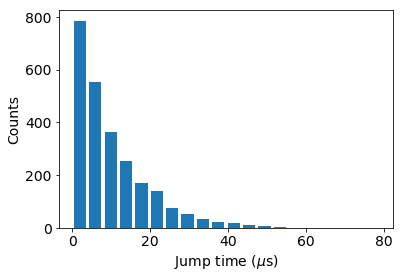

In [6]:
tlist = np.linspace(0, 10*T1, 1001)
# Run Monte Carlo for 5000 trajectories
result = qt.mcsolve(H, psi0, tlist, cops, eops, ntraj=5000)
# Find trajectories that contain jumps and save the jump time
jumptimes = np.array([j for j in result.col_times if j.any()])

print('\nTotal number of trajectories: ', result.ntraj)
print('Number of trajectories that contain jumps: ', len(jumptimes))
# Plot histogram for jump time
plt.figure()
plt.hist(jumptimes, 20, rwidth=0.8)
plt.xlabel(r'Jump time ($\mu$s)')
plt.ylabel('Counts')
plt.show()

We see half of the trajectories do not contain jumps and the other half that contain jumps show an exponential distribution of jump time.

In [7]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.3.0.dev0+0b447b2e
Numpy,1.13.3
SciPy,1.0.0
matplotlib,2.1.0
Cython,0.26.1
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,6.1.0
Python,"3.6.3 |Anaconda, Inc.| (default, Nov 9 2017, 00:19:18) [GCC 7.2.0]"
OS,posix [linux]
